<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
ELEC PRICE PREDICTION CAPSTONE:</font>  

<font size='4'>Electricity Price DataFrame Creation Notebook  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; (Down-sampled to hourly)
</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Manu Kalia Project Submission<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; DSI-7-SF<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15-May-2019<br>
</font>

---


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Day-Ahead-Market-DataFrame" data-toc-modified-id="Day-Ahead-Market-DataFrame-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Day-Ahead-Market DataFrame</a></span></li><li><span><a href="#Hour-Ahead-Scheduling-Process-DataFrame" data-toc-modified-id="Hour-Ahead-Scheduling-Process-DataFrame-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hour-Ahead-Scheduling Process DataFrame</a></span></li><li><span><a href="#RTM-DataFrame" data-toc-modified-id="RTM-DataFrame-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>RTM DataFrame</a></span></li><li><span><a href="#Join-DAM-+-HASP-+-RTM-LMP's-Into-a-Single-DataFrame" data-toc-modified-id="Join-DAM-+-HASP-+-RTM-LMP's-Into-a-Single-DataFrame-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Join DAM + HASP + RTM LMP's Into a Single DataFrame</a></span></li></ul></div>

---

## Imports

In [1]:
import pandas as pd
import numpy as np

import wget, os
import time
import glob

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
sns.set_style('whitegrid')

---

## Day-Ahead-Market DataFrame

In [2]:
dam_orig_cols=['INTERVALSTARTTIME_GMT',
               'OPR_DT',
               'OPR_HR',
               'NODE',
               'MARKET_RUN_ID',
               'LMP_TYPE',
               'MW']

dam_new_cols =['start_datetime',
               'date',
               'hr_index',
               'node',
               'market',
               'lmp_type',
               'dam_price_per_mwh']

dam_rename_dict = {old: new for old, new in zip(dam_orig_cols, dam_new_cols)}

In [3]:
caiso_dam_df = pd.DataFrame(columns=dam_new_cols)

for file in glob.glob('../unzipped_caiso/unzipped_caiso_dam/*.csv'):
    df = pd.read_csv(file, usecols=dam_orig_cols).rename(index=str,
                                                         columns=dam_rename_dict)
    df = df[df.lmp_type == 'LMP']
    caiso_dam_df = caiso_dam_df.append(df, ignore_index=True)

In [4]:
caiso_dam_df.shape

(29149, 7)

In [5]:
caiso_dam_df = caiso_dam_df.sort_values(by='start_datetime').reset_index(drop=True)

caiso_dam_df['start_datetime'] = pd.to_datetime(caiso_dam_df['start_datetime'])

caiso_dam_df.set_index('start_datetime', inplace=True)
caiso_dam_df.sort_index(inplace=True)
caiso_dam_df.head()

,date,hr_index,node,market,lmp_type,dam_price_per_mwh
start_datetime,,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,DAM,LMP,31.69690
2016-01-01 09:00:00+00:00,2016-01-01,2,BAYSHOR2_1_N001,DAM,LMP,30.38613
2016-01-01 10:00:00+00:00,2016-01-01,3,BAYSHOR2_1_N001,DAM,LMP,30.29141
2016-01-01 11:00:00+00:00,2016-01-01,4,BAYSHOR2_1_N001,DAM,LMP,28.45127
2016-01-01 12:00:00+00:00,2016-01-01,5,BAYSHOR2_1_N001,DAM,LMP,28.66504


In [6]:
caiso_dam_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29149 entries, 2016-01-01 08:00:00+00:00 to 2019-05-01 06:00:00+00:00
Data columns (total 6 columns):
date                 29149 non-null object
hr_index             29149 non-null object
node                 29149 non-null object
market               29149 non-null object
lmp_type             29149 non-null object
dam_price_per_mwh    29149 non-null float64
dtypes: float64(1), object(5)
memory usage: 1.6+ MB


---

## Hour-Ahead-Scheduling Process DataFrame
(hour-ahead, 15-minute realtime market)

In [7]:
hasp_orig_cols=['INTERVALSTARTTIME_GMT',
                'OPR_DT',
                'OPR_HR',
                'NODE',
                'MARKET_RUN_ID',
                'LMP_TYPE',
                'MW']

hasp_new_cols =['start_datetime',
                'date',
                'hr_index',
                'node',
                'market',
                'lmp_type',
                'hasp_price_per_mwh']

hasp_rename_dict = {old: new for old, new in zip(hasp_orig_cols, hasp_new_cols)}

In [8]:
caiso_hasp_df = pd.DataFrame(columns=hasp_new_cols)

for file in glob.glob('../unzipped_caiso/unzipped_caiso_hasp/*.csv'):
    df = pd.read_csv(file, usecols=hasp_orig_cols).rename(index=str,
                                                          columns=hasp_rename_dict)
    df = df[df.lmp_type == 'LMP']
    caiso_hasp_df = caiso_hasp_df.append(df, ignore_index=True)

In [9]:
caiso_hasp_df.shape

(116272, 7)

In [10]:
caiso_hasp_df = caiso_hasp_df.sort_values(by='start_datetime').reset_index(drop=True)

caiso_hasp_df['start_datetime'] = pd.to_datetime(caiso_hasp_df['start_datetime'])

caiso_hasp_df.set_index('start_datetime', inplace=True)
caiso_hasp_df.sort_index(inplace=True)
caiso_hasp_df.head()

,date,hr_index,node,market,lmp_type,hasp_price_per_mwh
start_datetime,,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,HASP,LMP,25.71969
2016-01-01 08:15:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,HASP,LMP,24.54000
2016-01-01 08:30:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,HASP,LMP,24.53352
2016-01-01 08:45:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,HASP,LMP,24.15808
2016-01-01 09:00:00+00:00,2016-01-01,2,BAYSHOR2_1_N001,HASP,LMP,25.32248


In [11]:
caiso_hasp_df = caiso_hasp_df.resample('H').mean()

In [12]:
caiso_hasp_df.head()

,hasp_price_per_mwh
start_datetime,
2016-01-01 08:00:00+00:00,24.737823
2016-01-01 09:00:00+00:00,25.030977
2016-01-01 10:00:00+00:00,24.563877
2016-01-01 11:00:00+00:00,24.775715
2016-01-01 12:00:00+00:00,24.923320


In [13]:
caiso_hasp_df.shape

(29183, 1)

---

## RTM DataFrame
(realtime spot prices, 5-minute realtime settlements only)

In [14]:
rtm_orig_cols=['INTERVALSTARTTIME_GMT',
                'OPR_DT',
                'OPR_HR',
                'NODE',
                'MARKET_RUN_ID',
                'LMP_TYPE',
                'VALUE']

rtm_new_cols =['start_datetime',
                'date',
                'hr_index',
                'node',
                'market',
                'lmp_type',
                'rtm_price_per_mwh']

rtm_rename_dict = {old: new for old, new in zip(rtm_orig_cols, rtm_new_cols)}

In [15]:
caiso_rtm_df = pd.DataFrame(columns=rtm_new_cols)

for file in glob.glob('../unzipped_caiso/unzipped_caiso_rtm/*.csv'):
    df = pd.read_csv(file, usecols=rtm_orig_cols).rename(index=str,
                                                          columns=rtm_rename_dict)
    df = df[df.lmp_type == 'LMP']
    caiso_rtm_df = caiso_rtm_df.append(df, ignore_index=True)

In [16]:
caiso_rtm_df.shape

(349728, 7)

In [17]:
caiso_rtm_df = caiso_rtm_df.sort_values(by='start_datetime').reset_index(drop=True)

caiso_rtm_df['start_datetime'] = pd.to_datetime(caiso_rtm_df['start_datetime'])

caiso_rtm_df.set_index('start_datetime', inplace=True)
caiso_rtm_df.sort_index(inplace=True)
caiso_rtm_df.head()

,date,hr_index,node,market,lmp_type,rtm_price_per_mwh
start_datetime,,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.53958
2016-01-01 08:05:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.24638
2016-01-01 08:10:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.54549
2016-01-01 08:15:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.23638
2016-01-01 08:20:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.23638


In [18]:
caiso_rtm_df = caiso_rtm_df.resample('H').mean()

In [19]:
caiso_rtm_df.head()

,rtm_price_per_mwh
start_datetime,
2016-01-01 08:00:00+00:00,25.219949
2016-01-01 09:00:00+00:00,24.903873
2016-01-01 10:00:00+00:00,24.630057
2016-01-01 11:00:00+00:00,24.689828
2016-01-01 12:00:00+00:00,23.505206


In [20]:
caiso_rtm_df.shape

(29183, 1)

---

## Join DAM + HASP + RTM LMP's Into a Single DataFrame

In [21]:
elec_prices_hrly = caiso_dam_df.drop(columns=['market', 'lmp_type'])
elec_prices_hrly.shape

(29149, 4)

In [22]:
elec_prices_hrly.head()

,date,hr_index,node,dam_price_per_mwh
start_datetime,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,31.69690
2016-01-01 09:00:00+00:00,2016-01-01,2,BAYSHOR2_1_N001,30.38613
2016-01-01 10:00:00+00:00,2016-01-01,3,BAYSHOR2_1_N001,30.29141
2016-01-01 11:00:00+00:00,2016-01-01,4,BAYSHOR2_1_N001,28.45127
2016-01-01 12:00:00+00:00,2016-01-01,5,BAYSHOR2_1_N001,28.66504


In [23]:
elec_prices_hrly = elec_prices_hrly.merge(caiso_hasp_df[['hasp_price_per_mwh']],
                              how='outer',
                              left_index = True,
                              right_index = True)
elec_prices_hrly.shape

(29183, 5)

In [24]:
elec_prices_hrly.head(15)

,date,hr_index,node,dam_price_per_mwh,hasp_price_per_mwh
start_datetime,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,31.69690,24.737823
2016-01-01 09:00:00+00:00,2016-01-01,2,BAYSHOR2_1_N001,30.38613,25.030977
2016-01-01 10:00:00+00:00,2016-01-01,3,BAYSHOR2_1_N001,30.29141,24.563877
2016-01-01 11:00:00+00:00,2016-01-01,4,BAYSHOR2_1_N001,28.45127,24.775715
2016-01-01 12:00:00+00:00,2016-01-01,5,BAYSHOR2_1_N001,28.66504,24.923320
2016-01-01 13:00:00+00:00,2016-01-01,6,BAYSHOR2_1_N001,29.84836,25.353155
2016-01-01 14:00:00+00:00,2016-01-01,7,BAYSHOR2_1_N001,31.32447,24.827470
2016-01-01 15:00:00+00:00,2016-01-01,8,BAYSHOR2_1_N001,30.84077,24.542012
2016-01-01 16:00:00+00:00,2016-01-01,9,BAYSHOR2_1_N001,28.37561,23.686425


In [25]:
elec_prices_hrly = elec_prices_hrly.merge(caiso_rtm_df[['rtm_price_per_mwh']],
                              how='outer',
                              left_index = True,
                              right_index = True)
elec_prices_hrly.shape

(29183, 6)

In [26]:
elec_prices_hrly.head()

,date,hr_index,node,dam_price_per_mwh,hasp_price_per_mwh,rtm_price_per_mwh
start_datetime,,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,31.69690,24.737823,25.219949
2016-01-01 09:00:00+00:00,2016-01-01,2,BAYSHOR2_1_N001,30.38613,25.030977,24.903873
2016-01-01 10:00:00+00:00,2016-01-01,3,BAYSHOR2_1_N001,30.29141,24.563877,24.630057
2016-01-01 11:00:00+00:00,2016-01-01,4,BAYSHOR2_1_N001,28.45127,24.775715,24.689828
2016-01-01 12:00:00+00:00,2016-01-01,5,BAYSHOR2_1_N001,28.66504,24.923320,23.505206


In [27]:
elec_prices_hrly.shape

(29183, 6)

In [28]:
elec_prices_hrly.isna().sum()

date                   34
hr_index               34
node                   34
dam_price_per_mwh      34
hasp_price_per_mwh    115
rtm_price_per_mwh      39
dtype: int64

In [29]:
elec_prices_hrly = elec_prices_hrly[elec_prices_hrly.hasp_price_per_mwh.notna()]

In [30]:
elec_prices_hrly.isna().sum()

date                  0
hr_index              0
node                  0
dam_price_per_mwh     0
hasp_price_per_mwh    0
rtm_price_per_mwh     5
dtype: int64

In [31]:
elec_prices_hrly[elec_prices_hrly.rtm_price_per_mwh.isna()]

,date,hr_index,node,dam_price_per_mwh,hasp_price_per_mwh,rtm_price_per_mwh
start_datetime,,,,,,
2016-02-01 07:00:00+00:00,2016-01-31,24,BAYSHOR2_1_N001,22.61298,26.072322,NaN
2016-03-01 07:00:00+00:00,2016-02-29,24,BAYSHOR2_1_N001,21.89684,18.440703,NaN
2016-04-01 07:00:00+00:00,2016-04-01,1,BAYSHOR2_1_N001,18.33026,14.306255,NaN
2016-05-01 07:00:00+00:00,2016-05-01,1,BAYSHOR2_1_N001,25.80279,27.382132,NaN
2016-07-01 07:00:00+00:00,2016-07-01,1,BAYSHOR2_1_N001,23.42191,29.992988,NaN


In [32]:
elec_prices_hrly.rtm_price_per_mwh.fillna(method='ffill', inplace=True)

In [33]:
elec_prices_hrly.isna().sum().sum()

0

In [36]:
# elec_prices_hrly.to_csv('../data/elec_prices_hrly.csv')

''

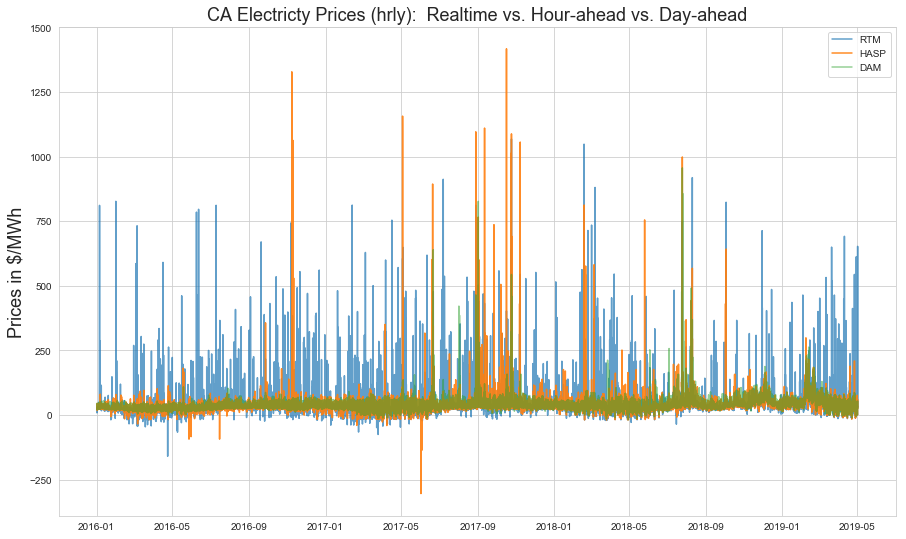

In [37]:
plt.figure(figsize=(15,9))
plt.title('CA Electricty Prices (hrly):  Realtime vs. Hour-ahead vs. Day-ahead', fontsize=18)

plt.plot(elec_prices_hrly.index,
         elec_prices_hrly.rtm_price_per_mwh,
         label = 'RTM', alpha=0.7)

plt.plot(elec_prices_hrly.index,
         elec_prices_hrly.hasp_price_per_mwh,
         label= 'HASP', alpha=0.9)

plt.plot(elec_prices_hrly.index,
         elec_prices_hrly.dam_price_per_mwh,
         label = 'DAM', alpha=0.5)

plt.ylabel('Prices in $/MWh', fontsize=18)
plt.legend()
# plt.savefig('../images/elec_prices_hrly.jpg', bbox_inches='tight')
;